# PU / GEANT dependence

**Motivation:**

In the `Saliency` notebook, I was making a lot of saliency plot to probe the physics of what the network was learning. 
I was interested in one of the track origin pictures that put a surprisingly low weight on the PU + GEANT tracks in the jet.

<img src="../figures/saliency/hits/Db/noNorm/trkOrig_6.pdf" width="400">

This begged the question:
    
Are the gains that we're seeing over IP3D due to the network *learning* to ignore GEANT and PU tracks????
    
The first plot that Michael told me to make was to look at whether this was the case was to *evaluate* the net for jets w/o the PU + GEANT tracks.

Since this corresponds to evaluating the net in a domain where it was not trained, I'm not 100% sure that I'm going to see the 

**Other studies:**
- Look at some of the input distributions
- Make a new test set where I can tune the number of PU and GEANT tracks that I'm feeding into the net.



In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Step 1

Gain some more *intuition* for this problem... plot the relevant distributions.
- $n_{trks}^{HF}$, $n_{trks}^{frag}$, $n_{trks}^{PU}$, $n_{trks}^{GEANT}$
- And then the repeat these as the fraction of the $n_{trks}^{IP3D}$
- Maybe see if there's any dependence of these variables w/ jet $p_T$

In [5]:
dataFile = '../data/mc16d'
dataTag = '10k_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataFile,dataTag), key='jet_df')

trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataFile,dataTag))

In [6]:
jet_df.head()

LabDr_HadF    pt_orig  eta_orig  phi_orig          m  ip3d_llr   ip3d_pb  \
0         4.0  82.521891 -1.647832 -1.115594   7.076710  8.030893  0.070772   
1         4.0  72.872375  1.698972  2.003417   8.230029  3.700817  0.028174   
2         5.0  34.415184  2.089628 -0.551500   6.249995  5.713408  0.046954   
3        15.0  28.808963  1.997881  3.136153   4.981111 -1.069982  0.056802   
4         0.0  53.356875 -2.145085  2.970182  10.792096  1.418369  0.000938   

    ip3d_pc   ip3d_pu  ip3d_ntrk    ...      aliveAfterORmu        llr  \
0  0.002910  0.000023        4.0    ...                 1.0   6.596817   
1  0.010117  0.000696        4.0    ...                 1.0   2.755359   
2  0.003810  0.000155        4.0    ...                 1.0   1.964071   
3  0.125082  0.165595        2.0    ...                 1.0 -99.000000   
4  0.002009  0.000227        6.0    ...                 1.0 -99.000000   

        JVT         pt       eta  rnnip_pu  rnnip_pc  rnnip_pb  rnnip_ptau  \
0  0.998500  85.362094 -1.646813  0.017968  0.080970  0.895366    0.005695   
1  0.995474  65.487230  1.697786  0.128092  0.270342  0.586582    0.014983   
2  0.997876  35.314129  2.089185  0.002254  0.018693  0.978173    0.000880   
3  0.998573  25.361543  1.997358  0.632889  0.117815  0.063850    0.185446   
4  0.987650  55.109125 -2.144747  0.669229  0.171371  0.156907    0.002493   

      bH_Lxy  
0 -99.000000  
1 -99.000000  
2   6.741858  
3 -99.000000  
4 -99.000000  

[5 rows x 22 columns]

In [7]:
jet_df.columns

Index(['LabDr_HadF', 'pt_orig', 'eta_orig', 'phi_orig', 'm', 'ip3d_llr',
       'ip3d_pb', 'ip3d_pc', 'ip3d_pu', 'ip3d_ntrk', 'mv2c10', 'aliveAfterOR',
       'aliveAfterORmu', 'llr', 'JVT', 'pt', 'eta', 'rnnip_pu', 'rnnip_pc',
       'rnnip_pb', 'rnnip_ptau', 'bH_Lxy'],
      dtype='object')

In [11]:
np.sum(jet_df['aliveAfterORmu'] == False)

104

In [12]:
jet_df.loc[jet_df['aliveAfterORmu'] == False,'LabDr_HadF']

95      0.0
103     0.0
169     5.0
195     0.0
226     0.0
667     0.0
682     0.0
699     4.0
803     0.0
901     0.0
1032    0.0
1110    5.0
1149    0.0
1359    0.0
1365    0.0
1490    4.0
1579    0.0
1803    0.0
1812    0.0
1826    0.0
1923    0.0
2027    0.0
2035    5.0
2042    0.0
2198    0.0
2403    0.0
2678    0.0
2741    0.0
2754    5.0
2778    0.0
       ... 
6657    0.0
6752    0.0
6961    0.0
7004    0.0
7061    0.0
7266    0.0
7286    0.0
7297    5.0
7306    0.0
7650    0.0
7992    0.0
8016    0.0
8047    0.0
8087    0.0
8607    5.0
8684    0.0
9046    0.0
9080    0.0
9129    0.0
9234    0.0
9320    0.0
9338    0.0
9381    0.0
9640    0.0
9649    0.0
9702    5.0
9714    0.0
9779    0.0
9925    0.0
9939    0.0
Name: LabDr_HadF, Length: 104, dtype: float64

In [14]:
for pdg in [0,4,5]:

    n = np.sum(jet_df.loc[jet_df['aliveAfterORmu'] == False,'LabDr_HadF'] == pdg)
    print(pdg,n)

0 86
4 3
5 14


In [15]:
86+14+3

103

In [3]:
# Load in the data
dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm"
f = h5py.File("{}/data_{}.hdf5".format(dataFile,dataTag),"r")

X  = f['X_test'][:]
y  = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

In [4]:
trk_xr.loc[:,:'orig']

<xarray.DataArray (jet: 3000000, trk: 15, var: 27)>
[1215000000 values with dtype=float32]
Coordinates:
  * jet      (jet) int64 0 1 2 3 4 5 ... 2999995 2999996 2999997 2999998 2999999
  * trk      (trk) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * var      (var) object 'sd0' 'sz0' 'ip3d_grade' ... 'ptfrac' 'dr'

In [5]:
trk_xr.coords['var']

<xarray.DataArray 'var' (var: 27)>
array(['sd0', 'sz0', 'ip3d_grade', 'ip3d_llr', 'pt', 'eta', 'theta', 'phi',
       'orig', 'algo', 'nNextToInnHits', 'nInnHits', 'nBLHits',
       'nsharedBLHits', 'nsplitBLHits', 'nPixHits', 'nPixHoles',
       'nsharedPixHits', 'nsplitPixHits', 'nSCTHits', 'nSCTHoles',
       'nsharedSCTHits', 'expectBLayerHit', 'expectInnermostPixelLayerHit',
       'expectNextToInnermostPixelLayerHit', 'ptfrac', 'dr'], dtype=object)
Coordinates:
  * var      (var) object 'sd0' 'sz0' 'ip3d_grade' ... 'ptfrac' 'dr'

In [6]:
jet_df.columns

Index(['LabDr_HadF', 'pt_orig', 'eta_orig', 'phi_orig', 'm', 'ip3d_llr',
       'ip3d_pb', 'ip3d_pc', 'ip3d_pu', 'ip3d_ntrk', 'mv2c10', 'aliveAfterOR',
       'llr', 'JVT', 'pt', 'eta', 'rnnip_pu', 'rnnip_pc', 'rnnip_pb',
       'rnnip_ptau', 'bH_Lxy'],
      dtype='object')

In [7]:
trk_origs = trk_xr.loc[:,:,'orig'].values

In [8]:
trk_origs.shape

(3000000, 15)

In [9]:
print(trk_origs[0])

[ 1.  1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### Plan

- Add some *new* cols to the df to account for these track multiplicity variables.


- -1: PU
-  0: b-hadron
-  1: c-hadron
-  2: fragmentaion
-  3: GEANT

In [10]:
X_all = trk_xr.values

In [11]:
X_all.shape

(3000000, 15, 27)

In [12]:
for o, orig_tag, trk_label in zip([(0,1), 2, -1, 3], ['HF','frag','PU','GEANT'],
                                ['heavy flavor', "fragmentation", "pile-up", "GEANT"]):
    
    if type(o) == tuple:
        orig_mask = np.zeros(15, dtype=np.bool)
        for oi in o:
            orig_mask = orig_mask | (trk_origs == oi)
            
        # For this jet, I can't just *add* up the origin mask, b/c the b-jets have 
        # this variable assigned as the mask values
        trkExists = (np.sum(X_all, axis=-1) != 0)
        
        orig_mask = orig_mask & trkExists
        
    else:
        orig_mask = (trk_origs == o)
    
    key = 'ip3d_ntrk_' + orig_tag
    jet_df[key] = np.sum(orig_mask, axis=-1)
    

In [13]:
jet_df.head()

LabDr_HadF    pt_orig  eta_orig  phi_orig             m  ip3d_llr  \
0         4.0  82.521891 -1.647832 -1.115594   7076.710449  8.030893   
1         4.0  72.872375  1.698972  2.003417   8230.029297  3.700817   
2         5.0  34.415184  2.089628 -0.551500   6249.994629  5.713408   
3        15.0  28.808963  1.997881  3.136153   4981.111328 -1.069982   
4         0.0  53.356875 -2.145085  2.970182  10792.095703  1.418369   

    ip3d_pb   ip3d_pc   ip3d_pu  ip3d_ntrk       ...              eta  \
0  0.070772  0.002910  0.000023        4.0       ...        -1.646813   
1  0.028174  0.010117  0.000696        4.0       ...         1.697786   
2  0.046954  0.003810  0.000155        4.0       ...         2.089185   
3  0.056802  0.125082  0.165595        2.0       ...         1.997358   
4  0.000938  0.002009  0.000227        6.0       ...        -2.144747   

   rnnip_pu  rnnip_pc  rnnip_pb  rnnip_ptau     bH_Lxy  ip3d_ntrk_HF  \
0  0.017968  0.080970  0.895366    0.005695 -99.000000             2   
1  0.128092  0.270342  0.586582    0.014983 -99.000000             2   
2  0.002254  0.018693  0.978173    0.000880   6.741858             3   
3  0.632889  0.117815  0.063850    0.185446 -99.000000             0   
4  0.669229  0.171371  0.156907    0.002493 -99.000000             0   

   ip3d_ntrk_frag  ip3d_ntrk_PU  ip3d_ntrk_GEANT  
0               1             1                0  
1               2             0                0  
2               1             0                0  
3               2             0                0  
4               5             1                0  

[5 rows x 25 columns]

**Q:** How many PU / GEANT tracks on average are in the jet?

In [14]:
for orig_tag in ['HF','frag','PU','GEANT']:
    
    key = 'ip3d_ntrk_' + orig_tag
    print("{} = {:.2f}".format(orig_tag, jet_df[key].mean()))
    

HF = 1.40
frag = 3.19
PU = 0.29
GEANT = 0.08


In [15]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    mask = (jet_df.LabDr_HadF == pdg)
    print("{}-jets = {:.2f}".format(flav, jet_df.loc[mask,'ip3d_ntrk'].mean()))

l-jets = 4.71
c-jets = 5.19
b-jets = 5.91


How about if we broke this down by flavor?

In [16]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    print('\n{}-jets:'.format(flav))
    mask = (jet_df.LabDr_HadF == pdg)
    
    for orig_tag in ['HF','frag','PU','GEANT']:

        key = 'ip3d_ntrk_' + orig_tag
        print("    {} = {:.2f}".format(orig_tag, jet_df.loc[mask,key].mean()))


l-jets:
    HF = 0.00
    frag = 4.23
    PU = 0.31
    GEANT = 0.07

c-jets:
    HF = 1.72
    frag = 3.01
    PU = 0.27
    GEANT = 0.08

b-jets:
    HF = 3.41
    frag = 1.99
    PU = 0.29
    GEANT = 0.09


Ok, so to plot these distributions, maybe I should make a scheme for the colors and grades?

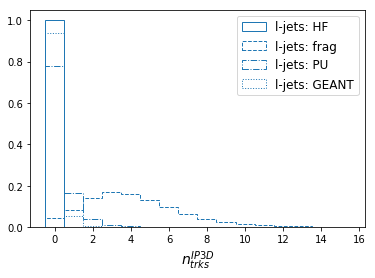

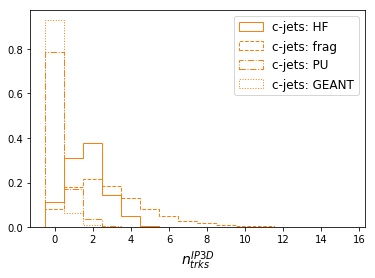

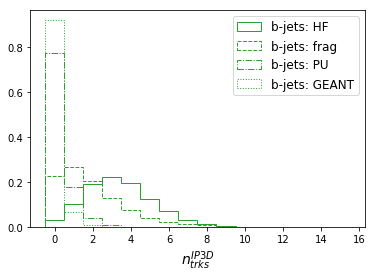

In [17]:
for yi, pdg, flav in zip(range(3), [0,4,5],['l','c','b']):

    mask = (jet_df.LabDr_HadF == pdg)
    plt.figure()
    
    for orig_tag, l in zip(['HF','frag','PU','GEANT'],
                           ['-', '--', '-.', ':']):
        
        key = 'ip3d_ntrk_' + orig_tag
        
        plt.hist(jet_df.loc[mask,key],range=(-0.5,15.5),bins=16,
                 histtype='step', density=True, # log=True,
                 color='C{}'.format(yi), linestyle=l,
                 label='{}-jets: {}'.format(flav,orig_tag))
     
    plt.legend(fontsize=12)   
    plt.xlabel('$n_{trks}^{IP3D}$',fontsize=14)
plt.show()        

In [18]:
figDir = '../figures/PU_studies'

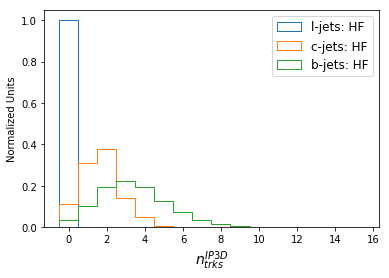

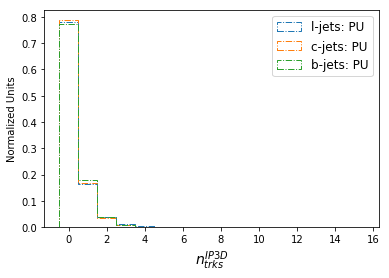

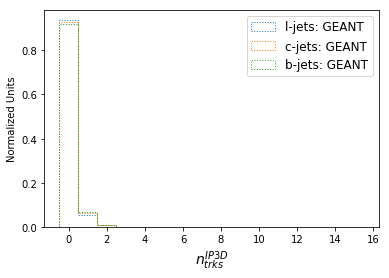

In [19]:
for orig_tag, l in zip(['HF','frag','PU','GEANT'],
                       ['-', '--', '-.', ':']):

    key = 'ip3d_ntrk_' + orig_tag
    plt.figure()
    
    for yi, pdg, flav in zip(range(3), [0,4,5],['l','c','b']):

        mask = (jet_df.LabDr_HadF == pdg)

        plt.hist(jet_df.loc[mask,key],range=(-0.5,15.5),bins=16,
                 histtype='step', density=True, 
                 color='C{}'.format(yi), linestyle=l,
                 label='{}-jets: {}'.format(flav,orig_tag))
     
    plt.legend(fontsize=12)   
    plt.xlabel('$n_{trks}^{IP3D}$',fontsize=14)
    plt.ylabel('Normalized Units')
    plt.savefig("{}/ip3d_ntrks_{}.pdf".format(figDir,orig_tag),
                bbox_inches='tight')
plt.show()        

**Conclusions:**
- Comparing with my truth studies from summer 2017, it seems like I'm often times *losing* tracks from ip3d.
- There are *way* more fragmentation tracks from the l-jets than the c + b-jets, maybe b/c of what Michael said about the l-jets having a more $p_T$ dependent fragmentation function?
- The number of PU and GEANT tracks is roughly the same between all three flavors, *as expected* since this shouldn't depend on the jet flavor

Next, let's consider modelling the number of PU and GEANT tracks as a Poisson distribution.

- Use the training set to do the fit (or derive the $\mu$ for the distribution)
- Use the $\chi^2$ test set to test the goodness of fit!


*First looking at the study for the PU tracks...*

In [20]:
n_obs, _ = np.histogram(jet_df['ip3d_ntrk_PU'],bins=16,
                        range=(-0.5,15.5), density=True)

In [21]:
n_obs

array([7.81323667e-01, 1.67250333e-01, 3.75780000e-02, 9.16200000e-03,
       2.69633333e-03, 1.03466667e-03, 4.56000000e-04, 2.38666667e-04,
       1.17666667e-04, 7.13333333e-05, 3.46666667e-05, 1.73333333e-05,
       1.03333333e-05, 3.00000000e-06, 2.66666667e-06, 3.33333333e-06])

The MLE estimate of a Poisson distribution is just the sample mean.

In [22]:
mu = jet_df['ip3d_ntrk_PU'].mean()
Ntot = len(jet_df.index)

In [23]:
Ntot

3000000

In [24]:
x = np.arange(16)

In [25]:
x_fact = np.array([np.math.factorial(xi) for xi in x])

In [26]:
n_exp = np.exp(-mu) * np.power(mu,x) / x_fact

In [27]:
n_exp

array([7.46299215e-01, 2.18388544e-01, 3.19533743e-02, 3.11682443e-03,
       2.28018045e-04, 1.33449233e-05, 6.50851184e-07, 2.72082449e-08,
       9.95239053e-10, 3.23594975e-11, 9.46931659e-13, 2.51908499e-14,
       6.14297068e-16, 1.38277640e-17, 2.89028582e-19, 5.63853656e-21])

In [28]:
from scipy.stats import chisquare

In [29]:
chisq, p = chisquare(n_obs, n_exp)

In [30]:
chisq

1996008015.6406834

In [31]:
p

0.0

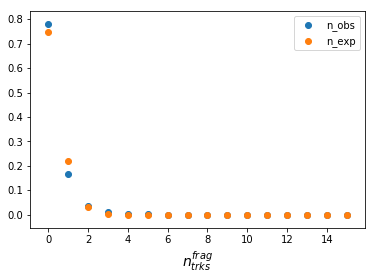

In [32]:
plt.scatter(x,n_obs,label='n_obs')
plt.scatter(x,n_exp,label='n_exp')
plt.xlabel('$n_{trks}^{frag}$',fontsize=14)
plt.legend()
plt.show()

*Question:*
So maybe I'm just not really understanding how to work with the $\chi^2$ test statistic, b/c it's *HUGE*. 

- It seems like a true Poisson distribution is more sharply falling than the spectrum that I'm seeing.
- But I think the lesson is if I do estimate the PU by throwing a Poissonian RV, the expected number of PU jets will be larger than in my original sample.

Other plots:
- Look at the correlations b/w the # of PU + GEANT tracks with the total number of jets?


Although the # of PU jets does not vary by

## Step 2

- Get the model
- Evaluate on the the jets w/o any tracks


In [33]:
doEmbedding=False
load_model=True
modelDir = "../models/mc16d/"

embedTag = 'gradeEmbed' if doEmbedding else 'noEmbed'
modelName = "LSTM_50units_10dense_{}_{}".format(dataTag,embedTag)

# Open the model
m = myLSTM(modelName=modelName, modelDir=modelDir, 
           loadModel=load_model, doEmbedding=doEmbedding)

Initialize method from myModel()
Loading previously trained LSTM


In [34]:
X_noGarbage = X.copy()
X_noPU = X.copy()
X_noGEANT = X.copy()
X_noFrag = X.copy()
X_onlyHF = X.copy()

In [35]:
test_trk_origs = trk_xr.loc[ix,:,'orig'].values

In [36]:
test_trk_origs.shape

(1500000, 15)

In [37]:
# -1: PU
#  3: GEANT

maskPU = (test_trk_origs == -1)
maskGEANT = (test_trk_origs == 3)
maskFrag = (test_trk_origs == 2)

maskGarbage = maskPU | maskGEANT
maskNotHF = maskGarbage | maskFrag

In [38]:
maskGarbage.shape

(1500000, 15)

In [39]:
maskGarbage.sum(axis=-1).mean()

0.373002

In [40]:
maskGarbage.shape

(1500000, 15)

Yep! Good sanity check, the mask is doing what I expect! :-)

In [41]:
X_noGarbage[maskGarbage,:] = 0
X_noPU[maskPU,:] = 0
X_noGEANT[maskGEANT,:] = 0
X_noFrag[maskFrag,:] = 0
X_onlyHF[maskNotHF,:] = 0

Sanity check: Just look at some of the distributions where a garbage track got masked

In [42]:
i_jet = 12
test_trk_origs[i_jet]

array([ 1.,  3.,  1.,  0.,  2.,  2.,  2.,  2.,  2.,  3.,  2., -1.,  0.,
        0.,  0.], dtype=float32)

In [43]:
# Compare the continuous vars
for i_trk in range(15):
    print('trk {}: '.format(i_trk+1))
    print('    X    :', X[i_jet,i_trk,:4])
    print('    X_new:', X_noGarbage[i_jet,i_trk,:4])

trk 1: 
    X    : [51.083405    5.8512063   0.40655488 -0.0580943 ]
    X_new: [51.083405    5.8512063   0.40655488 -0.0580943 ]
trk 2: 
    X    : [12.512785   -4.7712793  -1.5918996  -0.78048694]
    X_new: [0. 0. 0. 0.]
trk 3: 
    X    : [10.923761    3.4102125   0.9446961  -0.97063464]
    X_new: [10.923761    3.4102125   0.9446961  -0.97063464]
trk 4: 
    X    : [ 6.899797    6.9485793  -0.26003355 -1.3632603 ]
    X_new: [ 6.899797    6.9485793  -0.26003355 -1.3632603 ]
trk 5: 
    X    : [ 1.5629226  -0.12992477 -0.820915   -1.2804027 ]
    X_new: [ 1.5629226  -0.12992477 -0.820915   -1.2804027 ]
trk 6: 
    X    : [ 0.6077882  -0.05048379 -2.1478317   0.36335212]
    X_new: [ 0.6077882  -0.05048379 -2.1478317   0.36335212]
trk 7: 
    X    : [ 0.20059282  1.279404   -0.5911999   0.8797764 ]
    X_new: [ 0.20059282  1.279404   -0.5911999   0.8797764 ]
trk 8: 
    X    : [-0.310307   -0.1491929  -2.6488583   0.77395386]
    X_new: [-0.310307   -0.1491929  -2.6488583   0.773953

Ok, looks good! The relevant tracks are *masked* as expected.

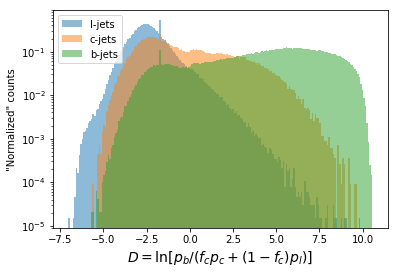

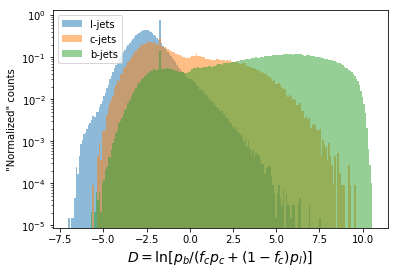

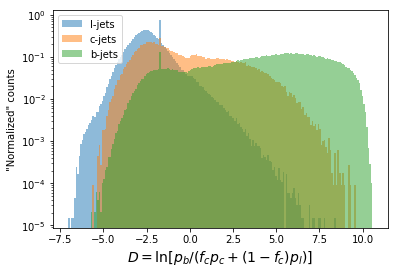

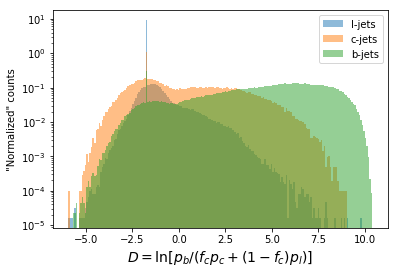

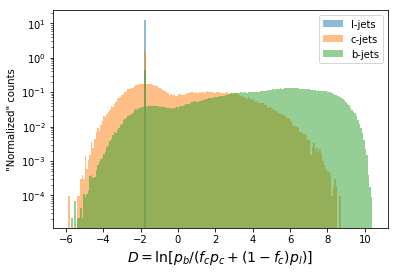

In [44]:
# Get the roc curves for the normal case and for the zero garbage case
leffs = []
ceffs = []
beffs = []

labels = ['test set', 'no garbage tracks','no PU', 'no GEANT', 'no fragmentation', 'only HF']

for Xi in [X, X_noGarbage, X_noPU, X_noGEANT, X_noFrag, X_onlyHF]:

    l_eff, c_eff, b_eff = sigBkgEff(m, Xi, y, ix)
    
    leffs.append(l_eff)
    ceffs.append(c_eff)
    beffs.append(b_eff)
    

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


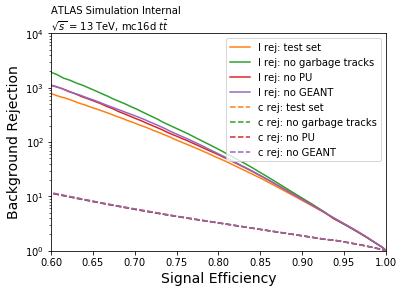

In [46]:
btagROC(beffs[:4], leffs[:4], ceffs[:4], labels[:4], colors=['C1','C2','C3','C4'],
        ymax=1e4,tag='PU_vs_GEANT',subDir='PU_studies')

So, perhaps our interpretation from the plot in the beginning of the notebook that the network was learning about PU and GEANT tracks was incorrect?

- Note this also supports separating out the PU + GEANT classes separately b/c perhaps they're different enough that this would in fact be useful?


In [56]:
btagROC(beffs, leffs, ceffs, labels, colors=['C1','C2','C3','C4','C5','C6'],
        ymax=1e4) #,tag='PU_vs_GEANT',subDir='PU_studies')

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


Ok, there are *a lot* of curves on this plot, so I want to be careful that I'm comparing the correct curves.
- orange versus brown: it's about the same, with the brown perhaps being a bit better?
- There's no pink curve for the net evaluate with tracks with only HF b/c l-jets don't have any HF tracks! (lol)

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


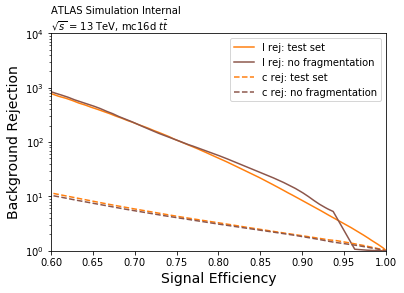

In [62]:
btagROC([beffs[0],beffs[-2]], 
        [leffs[0],leffs[-2]], 
        [ceffs[0],ceffs[-2]], 
        [labels[0],labels[-2]], colors=['C1','C5'],
        ymax=1e4,tag='noFrag',subDir='PU_studies')

It seems like removing frag trks might help the l classification a big, but hurt the c classification a bit.

But it's hard (at least for me) to draw a clear conclusion form this plot.

## More distributions:

- Plan: Plot the track distribuitons for each of the variables used by the network.

(I think it would be useful to separate this by the track origin like I did above

In [48]:
_, nTrks, nFeatures = X.shape

In [49]:
nFeatures

17

In [50]:
y.shape

(1500000,)

In [19]:
trk_vars = ['sd0', 'sz0', 'ptfrac', 'dr',
            "nNextToInnHits",
            "nInnHits",
            "nsharedBLHits",
            "nsplitBLHits",
            "nPixHits",
            "nsharedPixHits",
            "nsplitPixHits",
            "nSCTHits",
            "nsharedSCTHits",
            "ip3d_d0","ip3d_z0","prbP","pPerp","z0_sin"
            ]

xlabels = ['$s_{d0}$', '$s_{z0}', '$p_T^{frac}$', '$\Delta R$',
            "# of L1 hits",
            "# of L0 hits",
            "# of shared hits in L0",
            "# of split hits in L0",
            "# of pixel hits",
            "# of shared pixel hits",
            "# of split pixel hits",
            "# of SCT hits",
            "# of shared SCT hits",
            "$d_0$ [mm]","$z_0$ [mm]","prbP","$p_{perp}$ [MeV]", "$z_0 \sin \\theta$ [mm]"
            ]


var_ranges = [(-10,10), (-10,10), (0,1), (0, .4),
              (-0.5,4.5),
              (-0.5,4.5),
              (-0.5,4.5),
              (-0.5,4.5),
              (-0.5,9.5),
              (-0.5,9.5),
              (-0.5,9.5),
              (-0.5,20.5),
              (-0.5,20.5),
              (-1,1),
              (-1.5,1.5),
              (0,1),
              (0,40), #(0,0.04), use MeV instead
              (-1.5,1.5)
             ]

var_bins = [50,50,50,50,5,5,5,5,10,10,10,21,21,50,50,100,100,50]

In [32]:
len(trk_vars)

18

In [33]:
len(var_ranges)

18

In [34]:
len(var_bins)

18

For plotting all of the distributions, I need to be careful to *unscale* the $p_T^{frac}$ and $\Delta R$ variables.

In [5]:
nJets = int(3e6)
nTrks = 15
nFeatures = len(trk_vars)
X = np.zeros((nJets,nTrks,len(trk_vars)))

# The z0 sin(theta) is a variable that I need to derive, and can't just load in
for i,v in enumerate(trk_vars[:-1]):
    X[:,:,i] = trk_xr.loc[:,:,v].values
    
    # Rescale pPerp to MeV
    if v == 'pPerp':
        X[:,:,i] *= 1000 

X[:,:,-1] = trk_xr.loc[:,:,'ip3d_z0'].values * np.sin(trk_xr.loc[:,:,'theta'].values)

In [6]:
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.LabDr_HadF.replace(pdg_to_class).values

In [7]:
trk_origs = trk_xr.loc[:,:,'orig'].values

Sanity check: Ensure the IP selection cuts are satisfied
- $|d_0| < 1$ mm
- $|z_0 \sin(\theta)| < 1.5$ mm

In [8]:
# d0
i_d0 = -5
np.min(X[:,:,i_d0]), np.max(X[:,:,i_d0])

(-0.9999975562095642, 0.9999994039535522)

In [22]:
# z0
i_z0 = -4
np.min(X[:,:,i_z0]), np.max(X[:,:,i_z0])

(-1.499998688697815, 1.4999947547912598)

$z_0$ is also between -1.5 and 1.5 because since $|\sin \theta | < 1$, this means cutting on $|z_0 \sin \theta |$ is a *looser cut*.

In [9]:
# z0 sin(theta)
i_z0sin = -1
np.min(X[:,:,i_z0sin]),np.max(X[:,:,i_z0sin])

(-1.4989436864852905, 1.4999465942382812)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


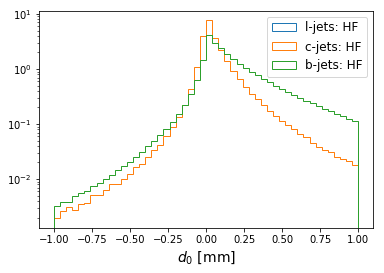

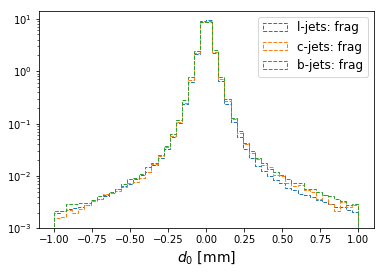

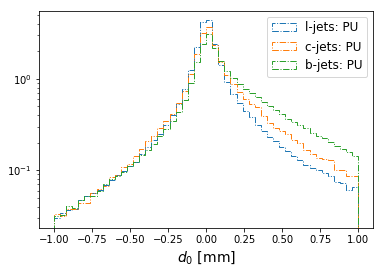

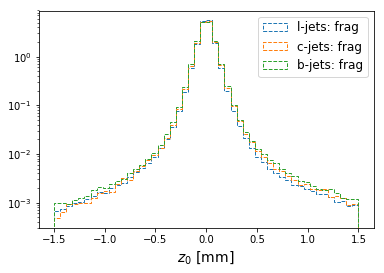

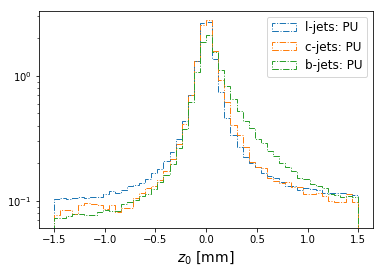

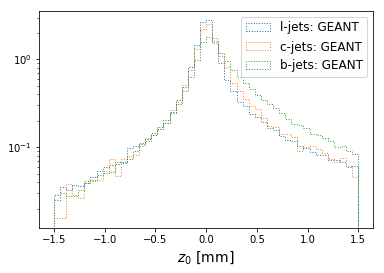

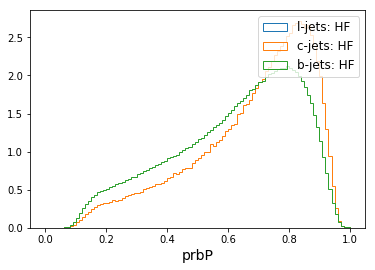

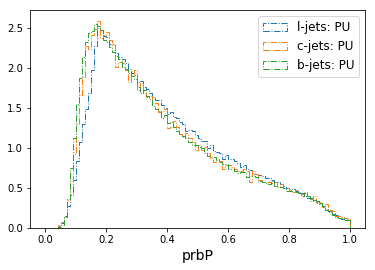

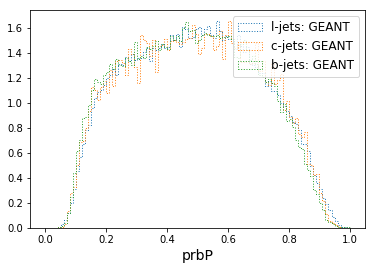

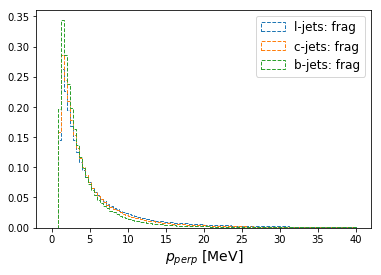

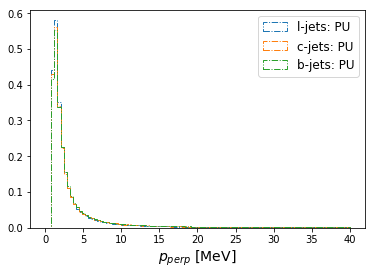

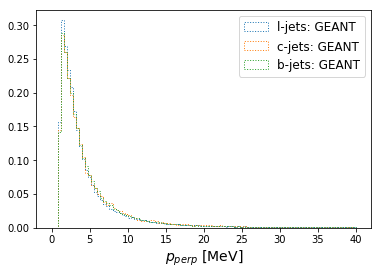

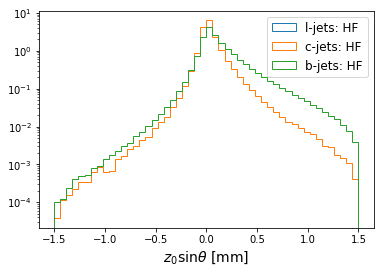

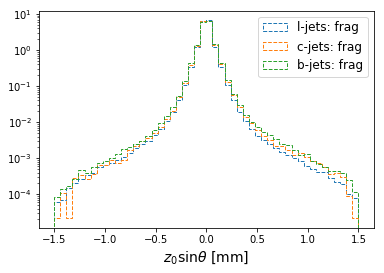

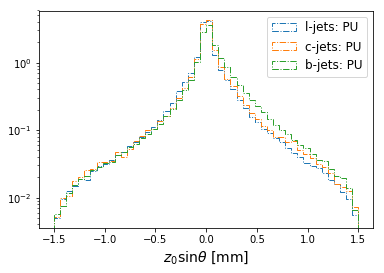

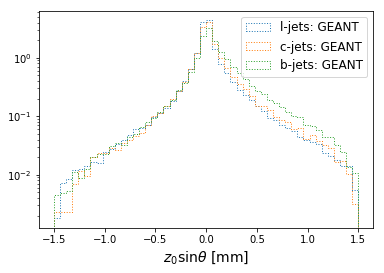

In [32]:
# Get the mask since all of the truth labels are track level variables
y_trks = np.ones_like(X[:,:,0])
y_trks = y_trks * y.reshape(-1,1)

o_trks = np.ones_like(X[:,:,0])
o_trks = o_trks * trk_origs

mask = getTrkMask(X)

# This mask selects the non-masked tracks in the jet
y_trks = y_trks[mask]
o_trks = o_trks[mask]
  
for j, trk_var, xlabel, nBins, myRange in zip(range(nFeatures)[-5:], trk_vars[-5:], xlabels[-5:], 
                                              var_bins[-5:], var_ranges[-5:]):

    # Access the non-masked trks in the jet for this trk feature
    var = X[:,:,j][mask]
    
    for oi, orig_tag, l in zip([(0,1),2,-1,3],['HF','frag','PU','GEANT'],
                               ['-', '--', '-.', ':']):

        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)
                
        plt.figure()

        for yi, flav in zip(range(3), ['l','c','b']):

            plt.hist(var[orig_mask & (y_trks == yi)],
                     range=myRange,bins=nBins,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,orig_tag))

        plt.legend(fontsize=12)  
        plt.xlabel(xlabel,fontsize=14)            
        plt.savefig('../figures/PU_studies/{}_{}.pdf'.format(trk_var,orig_tag))
        
        if ('d0' in trk_var) or ('z0' in trk_var):
            plt.yscale('log', nonposy='clip')
            plt.savefig('../figures/PU_studies/{}_{}_log.pdf'.format(trk_var,orig_tag))

        plt.show()
        

In [12]:
x = trk_xr.loc[:,0,'pPerp'].values

In [13]:
np.min(x), np.max(x)

(0.0, 165.91962)

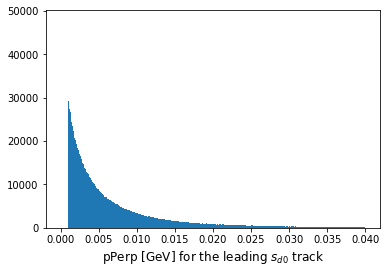

In [16]:
plt.hist(x,range=(0,.04),bins=1000)
plt.xlabel('pPerp [GeV] for the leading $s_{d0}$ track',fontsize=12)
plt.show()

**Follow-up from algorithms meeting:**
- How does this depend more on each of the garbage tracks, i.e, what if we mask PU and GEANT individually, which one makes the problem easier for the network?
    - From plots of distributions, it looks like there tend to be more PU tracks, but perhaps the GEANT tracks more easily will fake a b-hadron decay?
    - Michael also suggested trying it without the fragmentation tracks to see if that helps or hurts the network. 